In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (14, 8)
import numpy as np
from scipy import stats, integrate, optimize, interpolate
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
dist = stats.norm(175, 15)
q_grid = np.arange(120, 220)

### Penalty Function

In [3]:
n_reps = 100

@np.vectorize
def penalty(d, q, x, p):
    b = d - x - q
    return p*b if b > 0 else 0

sample_penalty = np.zeros((q_grid.shape[0], n_reps))
for i, q in enumerate(q_grid):
    samples = dist.rvs(n_reps)
    sample_penalty[i, :] = penalty(samples, q, 10, 5)
    
sample_penalty_flat = sample_penalty.T.flatten()
q_grid_flat = np.tile(q_grid, n_reps)

monte_carlo_penalty = np.mean(sample_penalty, axis=1)

@np.vectorize
def analytic_penalty(q, dist, x, p):
    return dist.expect(lambda u: p*(u - x - q), lb=(x+q))

analytical_value = analytic_penalty(q_grid, dist, 10, 5)

def func(x, a, b, c, d, e):
    return a*x**3 + b*x**2 + c*x + d


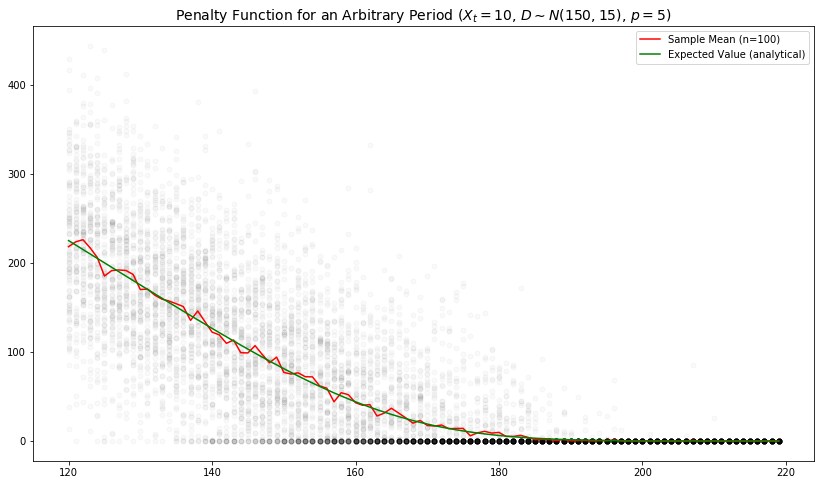

In [4]:
plt.clf()
plt.title("Penalty Function for an Arbitrary Period ($X_t = 10$, $D \sim N(150, 15)$, $p = 5$)", fontsize=14)
plt.plot(q_grid_flat, sample_penalty_flat, "ko", markersize=5, alpha=.025)
plt.plot(q_grid, monte_carlo_penalty, "r", label="Sample Mean (n=100)")
plt.plot(q_grid, analytical_value, "g", markersize=2, label="Expected Value (analytical)")
plt.legend()
plt.margins(tight=True)
plt.savefig("penalty.pdf")

### Holding Function

In [5]:
mean = np.repeat(175, 50)
std = np.repeat(15, 50)
dist = stats.multivariate_normal(mean, np.diag(np.square(std)))
n_reps = 100

def holding(d, q, x, h):
    cum_d = np.cumsum(d)
    z = cum_d - x
    H = q - z[np.where(z > 0)]
    return h*np.sum(H[np.where(H > 0)])

sample_holding = np.zeros((q_grid.shape[0], n_reps))
for i, q in enumerate(q_grid):
    samples = dist.rvs(n_reps)
    for j, s in enumerate(samples):
        sample_holding[i, j] = holding(s, q, 10, 1)
    
sample_holding_flat = sample_holding.T.flatten()
q_grid_flat = np.tile(q_grid, n_reps)

monte_carlo_holding = np.mean(sample_holding, axis=1)

def analytical_single_holding(q, dist, x, h):
    return dist.expect(lambda u: h*(x + q - u), lb=x, ub=(x+q))

def analytical_holding(q, mean, std, x, h):
    z = 0
    for m, v in zip(np.cumsum(mean), np.cumsum(np.square(std))):
        dist = stats.norm(m, np.sqrt(v))
        z += analytical_single_holding(q, dist, x, h)
    return z

analytical_value = np.zeros(q_grid.shape)
for i, q in enumerate(q_grid):
    analytical_value[i] = analytical_holding(q, mean, std, 10, 1)

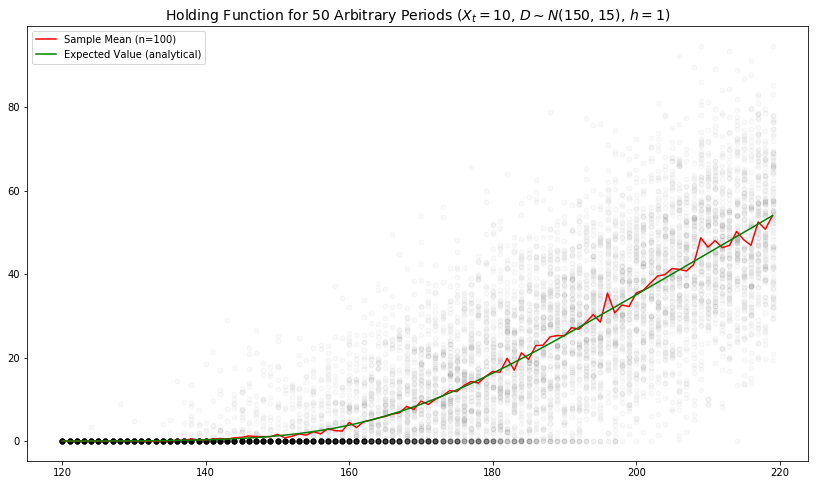

In [6]:
plt.clf()
plt.title("Holding Function for 50 Arbitrary Periods ($X_t = 10$, $D \sim N(150, 15)$, $h = 1$)", fontsize=14)
plt.plot(q_grid_flat, sample_holding_flat, "ko", markersize=5, alpha=.025)
plt.plot(q_grid, monte_carlo_holding, "r", label="Sample Mean (n=100)")
plt.plot(q_grid, analytical_value, "g", markersize=2, label="Expected Value (analytical)")
plt.legend()
plt.margins(tight=True)
plt.savefig("holding.pdf")

### The Loss Function

In [7]:
from scipy import interpolate

def balancing_loss(q, x, d_mean, d_std, p_cost, h_cost):
    dist = stats.norm(d_mean[0], d_std[0])
    penalty = dist.expect(lambda u: p_cost*(u - x - q), lb=(x+q))
    holding = 0
    for mean, var in zip(np.cumsum(d_mean), np.cumsum(np.square(d_std))):
        dist = stats.norm(mean, np.sqrt(var))
        held = dist.expect(lambda u: h_cost*(x + q - u), lb=x, ub=(x+q))
        holding += held
    return max(penalty, holding)

d_mean = np.repeat(175, 50)
d_std = np.repeat(15, 50)

analytical_value = np.zeros(q_grid.shape)
for i, q in enumerate(q_grid):
    analytical_value[i] = balancing_loss(q, 10, d_mean, d_std, 5, 1)

In [40]:
sampled_q = q_grid[::10]
sampled_q = np.append(sampled_q, [np.min(q_grid), np.max(q_grid)])
sampled_q = np.append(sampled_q, np.random.choice(q_grid, size=10))
sampled_q = np.sort(np.unique(sampled_q))
sampled_value = np.zeros(sampled_q.shape)
for i, q in enumerate(sampled_q):
    sampled_value[i] = balancing_loss(q, 10, d_mean, d_std, 5, 1)
interp = interpolate.interp1d(sampled_q, sampled_value, kind="quadratic")

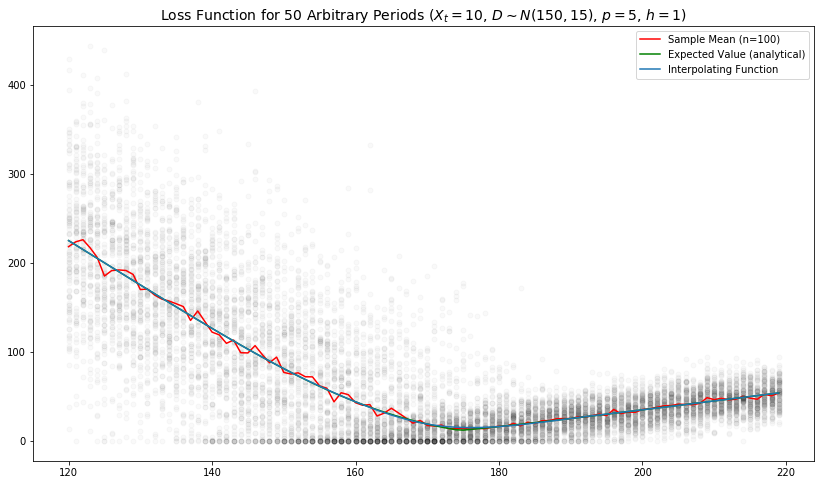

In [22]:
plt.clf()
plt.title("Loss Function for 50 Arbitrary Periods ($X_t = 10$, $D \sim N(150, 15)$, $p = 5$, $h = 1$)", fontsize=14)
plt.plot(q_grid_flat, [max(p, h) for p, h in zip(sample_penalty_flat, sample_holding_flat)], "ko", markersize=5, alpha=.025)
plt.plot(q_grid, [max(p, h) for p, h in zip(monte_carlo_penalty, monte_carlo_holding)], "r", label="Sample Mean (n=100)")
plt.plot(q_grid, analytical_value, "g", markersize=2, label="Expected Value (analytical)")
plt.legend()
plt.margins(tight=True)
plt.savefig("loss.pdf")

In [41]:
true_opt = optimize.fminbound(balancing_loss, 160, 200, args=(10, d_mean, d_std, 5, 1))
mc_opt = q_grid[np.argmin([max(p, h) for p, h in zip(monte_carlo_penalty, monte_carlo_holding)])]
approx_opt = optimize.fminbound(interp, 160, 200)
print(true_opt, mc_opt, approx_opt)

174.540410719 176 174.954130419


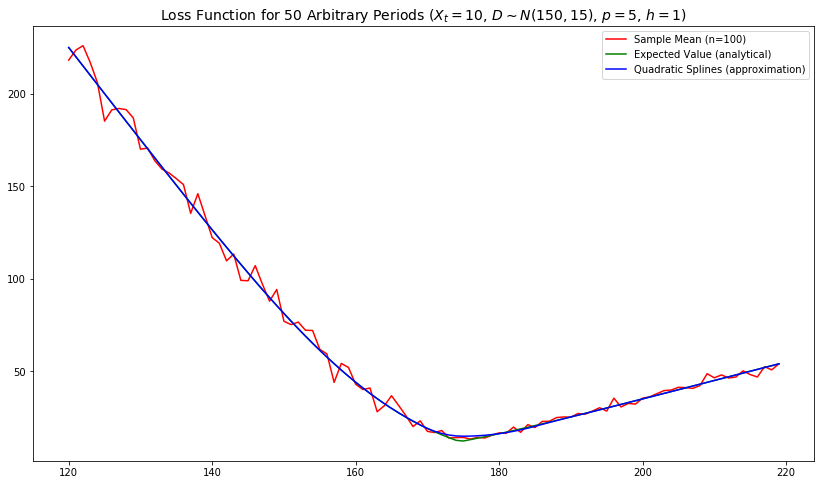

In [43]:
plt.clf()
plt.title("Loss Function for 50 Arbitrary Periods ($X_t = 10$, $D \sim N(150, 15)$, $p = 5$, $h = 1$)", fontsize=14)
plt.plot(q_grid, [max(p, h) for p, h in zip(monte_carlo_penalty, monte_carlo_holding)], "r", label="Sample Mean (n=100)")
plt.plot(q_grid, analytical_value, "g", markersize=2, label="Expected Value (analytical)")
plt.plot(q_grid, interp(q_grid), "b", markersize=2, label="Quadratic Splines (approximation)")
plt.legend()
plt.margins(tight=True)
plt.savefig("loss_approximate.pdf")

### Myopic